#### Import Modules

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import sys
import warnings
import os
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath(os.path.join('../scripts')))
from modeling_util import *
from LSTM_helper import *
from plot_util import *
from modeling_helper import get_categorical_columns, get_numerical_columns, cross_validation, plot_result, label_encoder

2022-11-06 13:50:22.361542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 13:50:26.582801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-06 13:50:26.582915: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-06 13:50:27.151077: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 13:50:34.526794: W tensorflow/stream_executor/platform/de

#### Read the encoded data

In [62]:
df_train = pd.read_csv("../data/df_all.csv")

In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             905 non-null    object 
 1   cta_start_x         905 non-null    float64
 2   cta_start_y         905 non-null    float64
 3   cta_end_x           905 non-null    float64
 4   cta_end_y           905 non-null    float64
 5   cta_height          905 non-null    float64
 6   cta_width           905 non-null    float64
 7   color_1             900 non-null    object 
 8   color_1_occurance   900 non-null    float64
 9   color_2             898 non-null    object 
 10  color_2_occurance   898 non-null    float64
 11  color_3             898 non-null    object 
 12  color_3_occurance   898 non-null    float64
 13  color_4             897 non-null    object 
 14  color_4_occurance   897 non-null    float64
 15  color_5             894 non-null    object 
 16  color_5_

In [64]:
df_train.drop(['game_id','color_1_occurance',
 'color_2_occurance',
 'color_3_occurance',
 'color_4_occurance', 'logo_start_x',
 'logo_start_y',
 'logo_end_x',
 'logo_end_y',
 'logo_height',
 'logo_width',
 'color_5_occurance',], inplace=True, axis=1)


In [65]:
df_train[['sentiment_a','sentiment_b']] = pd.get_dummies(df_train['sentiment'], columns=['sentiment'] , drop_first=True).values


In [34]:
non_numericals = ['color_3', 'color_2', 'color_4', 'color_5', 'color_1']


In [37]:
# label encode 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in non_numericals:
    df_train[col+'_l_encoded'] = le.fit_transform(df_train[col])

df_train.drop(columns=non_numericals, axis=1, inplace=True)

In [66]:
df_train.drop(columns =['sentiment'], inplace=True)


In [67]:
df_train.dtypes


cta_start_x           float64
cta_start_y           float64
cta_end_x             float64
cta_end_y             float64
cta_height            float64
cta_width             float64
color_1                object
color_2                object
color_3                object
color_4                object
color_5                object
audio_duration(ms)    float64
audio_intensity       float64
audio_frame_count     float64
beg_frame_angry       float64
beg_frame_disgust     float64
beg_frame_fear        float64
beg_frame_happy       float64
beg_frame_sad         float64
beg_frame_surprise    float64
beg_frame_neutral     float64
end_frame_angry       float64
end_frame_disgust     float64
end_frame_fear        float64
end_frame_happy       float64
end_frame_sad         float64
end_frame_surprise    float64
end_frame_neutral     float64
beg_frame_age         float64
end_frame_age         float64
sentiment_score       float64
word_count            float64
ER                    float64
CTR       

In [68]:
df_train.dropna(axis = 0, subset=['beg_frame_angry'], inplace=True)


In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605 entries, 0 to 904
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cta_start_x         605 non-null    float64
 1   cta_start_y         605 non-null    float64
 2   cta_end_x           605 non-null    float64
 3   cta_end_y           605 non-null    float64
 4   cta_height          605 non-null    float64
 5   cta_width           605 non-null    float64
 6   color_1             602 non-null    object 
 7   color_2             602 non-null    object 
 8   color_3             602 non-null    object 
 9   color_4             601 non-null    object 
 10  color_5             600 non-null    object 
 11  audio_duration(ms)  513 non-null    float64
 12  audio_intensity     513 non-null    float64
 13  audio_frame_count   513 non-null    float64
 14  beg_frame_angry     605 non-null    float64
 15  beg_frame_disgust   605 non-null    float64
 16  beg_fram

In [70]:
df_train.fillna(0, inplace=True)

In [115]:
df_train.dtypes.value_counts()

float64    29
object      5
uint8       2
dtype: int64

In [54]:
X = df_train.copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605 entries, 0 to 904
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cta_start_x         605 non-null    float64
 1   cta_start_y         605 non-null    float64
 2   cta_end_x           605 non-null    float64
 3   cta_end_y           605 non-null    float64
 4   cta_height          605 non-null    float64
 5   cta_width           605 non-null    float64
 6   audio_duration(ms)  605 non-null    float64
 7   audio_intensity     605 non-null    float64
 8   audio_frame_count   605 non-null    float64
 9   beg_frame_angry     605 non-null    float64
 10  beg_frame_disgust   605 non-null    float64
 11  beg_frame_fear      605 non-null    float64
 12  beg_frame_happy     605 non-null    float64
 13  beg_frame_sad       605 non-null    float64
 14  beg_frame_surprise  605 non-null    float64
 15  beg_frame_neutral   605 non-null    float64
 16  end_fram

In [119]:
df_train_encoded = pd.read_csv("../data/df_all_encoded.csv")
df_train_encoded.columns.tolist()

['game_id',
 'cta_start_x',
 'cta_start_y',
 'cta_end_x',
 'cta_end_y',
 'cta_height',
 'cta_width',
 'color_1_occurance',
 'color_2_occurance',
 'color_3_occurance',
 'color_4_occurance',
 'color_5_occurance',
 'audio_duration(ms)',
 'audio_intensity',
 'audio_frame_count',
 'beg_frame_angry',
 'beg_frame_disgust',
 'beg_frame_fear',
 'beg_frame_happy',
 'beg_frame_sad',
 'beg_frame_surprise',
 'beg_frame_neutral',
 'end_frame_angry',
 'end_frame_disgust',
 'end_frame_fear',
 'end_frame_happy',
 'end_frame_sad',
 'end_frame_surprise',
 'end_frame_neutral',
 'beg_frame_age',
 'end_frame_age',
 'sentiment_score',
 'word_count',
 'ER',
 'CTR',
 'sentiment_a',
 'sentiment_b',
 'color_3_l_encoded',
 'color_2_l_encoded',
 'color_4_l_encoded',
 'color_5_l_encoded',
 'color_1_l_encoded']

In [120]:
def return_position_val(x,y):
    if x < 300 and y < 300:
        return "top_left"
    elif x < 300 and y < 600:
        return "center_left"
    elif x < 300 and y < 900:
        return "bottom_left"
    elif x < 600 and y < 300:
        return "top_center"
    elif x < 600 and y < 600:
        return "center"
    elif x < 600 and y < 900:
        return "bottom_center"
    elif x < 940 and y < 300:
        return "top_right"
    elif x < 940 and y < 600:
        return "top_center"
    else: return "bottom_right"

In [121]:
def encode_coordinates(df):
    encoded_val = []
    for i,row in df.iterrows():
        encoded_val.append(return_position_val(row['cta_start_x'],row['cta_start_y']))
    return encoded_val

In [122]:
def calc_area(df):
    area = []
    for i,row in df.iterrows():
        area.append(row['cta_width']*row['cta_height'])
    return area

In [123]:
df_train_encoded['cta_position'] = encode_coordinates(df_train_encoded)
df_train_encoded['cta_position'].value_counts()

bottom_left      208
top_left         128
bottom_center    113
center_left       58
top_center        57
center            21
bottom_right      10
top_right         10
Name: cta_position, dtype: int64

In [124]:
df_train_encoded['area'] = calc_area(df_train_encoded)
df_train_encoded['area'].describe()

count       605.000000
mean      40400.800000
std       96372.588063
min        1064.000000
25%       11700.000000
50%       16940.000000
75%       21600.000000
max      540000.000000
Name: area, dtype: float64

In [125]:
cols = ['cta_start_x', 'cta_start_y', 'cta_end_x', 'cta_end_y',
       'cta_height', 'cta_width','color_1_occurance',
 'color_2_occurance',
 'color_3_occurance',
 'color_4_occurance',
 'color_5_occurance',]
df_train_encoded.drop(cols, inplace=True, axis=1)
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             605 non-null    object 
 1   audio_duration(ms)  605 non-null    float64
 2   audio_intensity     605 non-null    float64
 3   audio_frame_count   605 non-null    float64
 4   beg_frame_angry     605 non-null    float64
 5   beg_frame_disgust   605 non-null    float64
 6   beg_frame_fear      605 non-null    float64
 7   beg_frame_happy     605 non-null    float64
 8   beg_frame_sad       605 non-null    float64
 9   beg_frame_surprise  605 non-null    float64
 10  beg_frame_neutral   605 non-null    float64
 11  end_frame_angry     605 non-null    float64
 12  end_frame_disgust   605 non-null    float64
 13  end_frame_fear      605 non-null    float64
 14  end_frame_happy     605 non-null    float64
 15  end_frame_sad       605 non-null    float64
 16  end_fram

In [126]:
df_train_encoded.drop(['game_id'], inplace=True, axis=1)

In [127]:
numerical_cols = get_numerical_columns(df_train_encoded)
categorical_cols = get_categorical_columns(df_train_encoded)

In [ ]:
import numpy as np

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [128]:
df = clean_dataset(df_train_encoded[numerical_cols])

/tmp/ipykernel_387606/1366205758.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/tmp/ipykernel_387606/1366205758.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 0 to 603
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   audio_duration(ms)  383 non-null    float64
 1   audio_intensity     383 non-null    float64
 2   audio_frame_count   383 non-null    float64
 3   beg_frame_angry     383 non-null    float64
 4   beg_frame_disgust   383 non-null    float64
 5   beg_frame_fear      383 non-null    float64
 6   beg_frame_happy     383 non-null    float64
 7   beg_frame_sad       383 non-null    float64
 8   beg_frame_surprise  383 non-null    float64
 9   beg_frame_neutral   383 non-null    float64
 10  end_frame_angry     383 non-null    float64
 11  end_frame_disgust   383 non-null    float64
 12  end_frame_fear      383 non-null    float64
 13  end_frame_happy     383 non-null    float64
 14  end_frame_sad       383 non-null    float64
 15  end_frame_surprise  383 non-null    float64
 16  end_fram

In [147]:
X = df.copy()

In [139]:
X.dropna(inplace=True)

In [140]:
X['cta_position'] = df_train_encoded['cta_position']

#### ER Predictor

In [148]:
y = X['ER']
X=X.drop(['ER','CTR'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 0 to 603
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   audio_duration(ms)  383 non-null    float64
 1   audio_intensity     383 non-null    float64
 2   audio_frame_count   383 non-null    float64
 3   beg_frame_angry     383 non-null    float64
 4   beg_frame_disgust   383 non-null    float64
 5   beg_frame_fear      383 non-null    float64
 6   beg_frame_happy     383 non-null    float64
 7   beg_frame_sad       383 non-null    float64
 8   beg_frame_surprise  383 non-null    float64
 9   beg_frame_neutral   383 non-null    float64
 10  end_frame_angry     383 non-null    float64
 11  end_frame_disgust   383 non-null    float64
 12  end_frame_fear      383 non-null    float64
 13  end_frame_happy     383 non-null    float64
 14  end_frame_sad       383 non-null    float64
 15  end_frame_surprise  383 non-null    float64
 16  end_fram

#### Train Random Forest Model

In [142]:
X.dtypes.value_counts()

float64    30
object      1
dtype: int64

In [149]:
X.columns.tolist()

['audio_duration(ms)',
 'audio_intensity',
 'audio_frame_count',
 'beg_frame_angry',
 'beg_frame_disgust',
 'beg_frame_fear',
 'beg_frame_happy',
 'beg_frame_sad',
 'beg_frame_surprise',
 'beg_frame_neutral',
 'end_frame_angry',
 'end_frame_disgust',
 'end_frame_fear',
 'end_frame_happy',
 'end_frame_sad',
 'end_frame_surprise',
 'end_frame_neutral',
 'beg_frame_age',
 'end_frame_age',
 'sentiment_score',
 'word_count',
 'sentiment_a',
 'sentiment_b',
 'color_3_l_encoded',
 'color_2_l_encoded',
 'color_4_l_encoded',
 'color_5_l_encoded',
 'color_1_l_encoded',
 'area']

In [150]:
model = RandomForestRegressor(max_depth=64, random_state=0)
str(model)

'RandomForestRegressor(max_depth=64, random_state=0)'

feature importance plotted


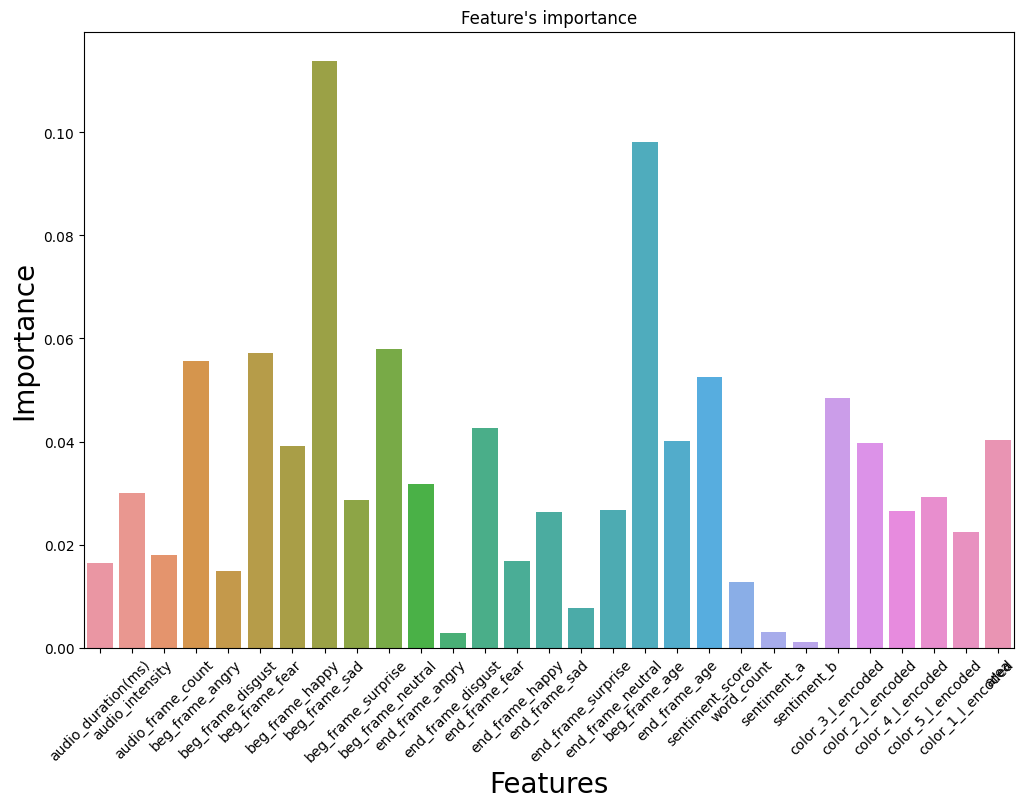

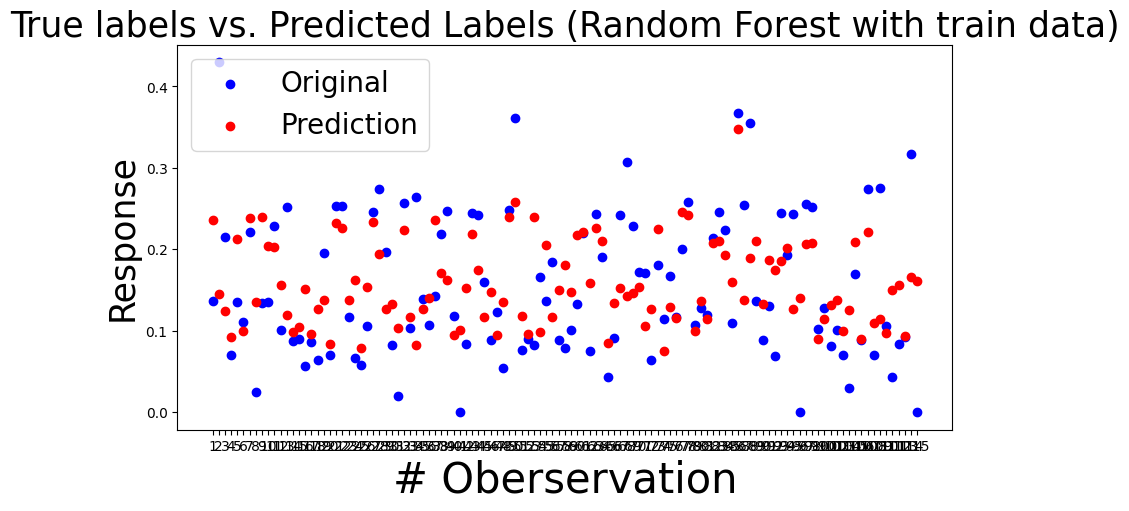

plotted prediction vs true labels
{'RMSE Score': 0.08, 'R2_Squared': 0.25, 'MAE Score': 0.06}
{'Accuracy': 47.76}
{'audio_duration(ms)': 0.016401378149869084, 'audio_intensity': 0.030052569928658665, 'audio_frame_count': 0.01793467173042125, 'beg_frame_angry': 0.05554890405347302, 'beg_frame_disgust': 0.014829871698950425, 'beg_frame_fear': 0.05714479105666914, 'beg_frame_happy': 0.039070856477805005, 'beg_frame_sad': 0.11387198411512561, 'beg_frame_surprise': 0.02861452692177608, 'beg_frame_neutral': 0.057943872377960545, 'end_frame_angry': 0.031763738343616614, 'end_frame_disgust': 0.002881516923291055, 'end_frame_fear': 0.04262361864310391, 'end_frame_happy': 0.01679477804430958, 'end_frame_sad': 0.026317649468638495, 'end_frame_surprise': 0.007653113703727981, 'end_frame_neutral': 0.02663714681991759, 'beg_frame_age': 0.09810295541068836, 'end_frame_age': 0.040003866661215554, 'sentiment_score': 0.052469185224576664, 'word_count': 0.012767708754409293, 'sentiment_a': 0.002967577846

{'RMSE Score': 0.08, 'R2_Squared': 0.25, 'MAE Score': 0.06}

In [151]:
run_train_pipeline(model, X, y, 
    experiment_name='Random Forest with train data',
    run_name='RandomForestRegressor(max_depth=64, random_state=0)')

#### Random Forest Model for CTR

In [152]:
X = df.copy()

In [153]:
X.dropna(inplace=True)

In [154]:
X['cta_position'] = df_train_encoded['cta_position']

In [155]:
y = X['CTR']
X=X.drop(['ER','CTR'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 0 to 603
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   audio_duration(ms)  383 non-null    float64
 1   audio_intensity     383 non-null    float64
 2   audio_frame_count   383 non-null    float64
 3   beg_frame_angry     383 non-null    float64
 4   beg_frame_disgust   383 non-null    float64
 5   beg_frame_fear      383 non-null    float64
 6   beg_frame_happy     383 non-null    float64
 7   beg_frame_sad       383 non-null    float64
 8   beg_frame_surprise  383 non-null    float64
 9   beg_frame_neutral   383 non-null    float64
 10  end_frame_angry     383 non-null    float64
 11  end_frame_disgust   383 non-null    float64
 12  end_frame_fear      383 non-null    float64
 13  end_frame_happy     383 non-null    float64
 14  end_frame_sad       383 non-null    float64
 15  end_frame_surprise  383 non-null    float64
 16  end_fram

In [156]:
X.dtypes.value_counts()

float64    29
object      1
dtype: int64

In [157]:
X.columns.tolist()


['audio_duration(ms)',
 'audio_intensity',
 'audio_frame_count',
 'beg_frame_angry',
 'beg_frame_disgust',
 'beg_frame_fear',
 'beg_frame_happy',
 'beg_frame_sad',
 'beg_frame_surprise',
 'beg_frame_neutral',
 'end_frame_angry',
 'end_frame_disgust',
 'end_frame_fear',
 'end_frame_happy',
 'end_frame_sad',
 'end_frame_surprise',
 'end_frame_neutral',
 'beg_frame_age',
 'end_frame_age',
 'sentiment_score',
 'word_count',
 'sentiment_a',
 'sentiment_b',
 'color_3_l_encoded',
 'color_2_l_encoded',
 'color_4_l_encoded',
 'color_5_l_encoded',
 'color_1_l_encoded',
 'area',
 'cta_position']

In [158]:
model = RandomForestRegressor(max_depth=64, random_state=0)
str(model)

'RandomForestRegressor(max_depth=64, random_state=0)'

feature importance plotted


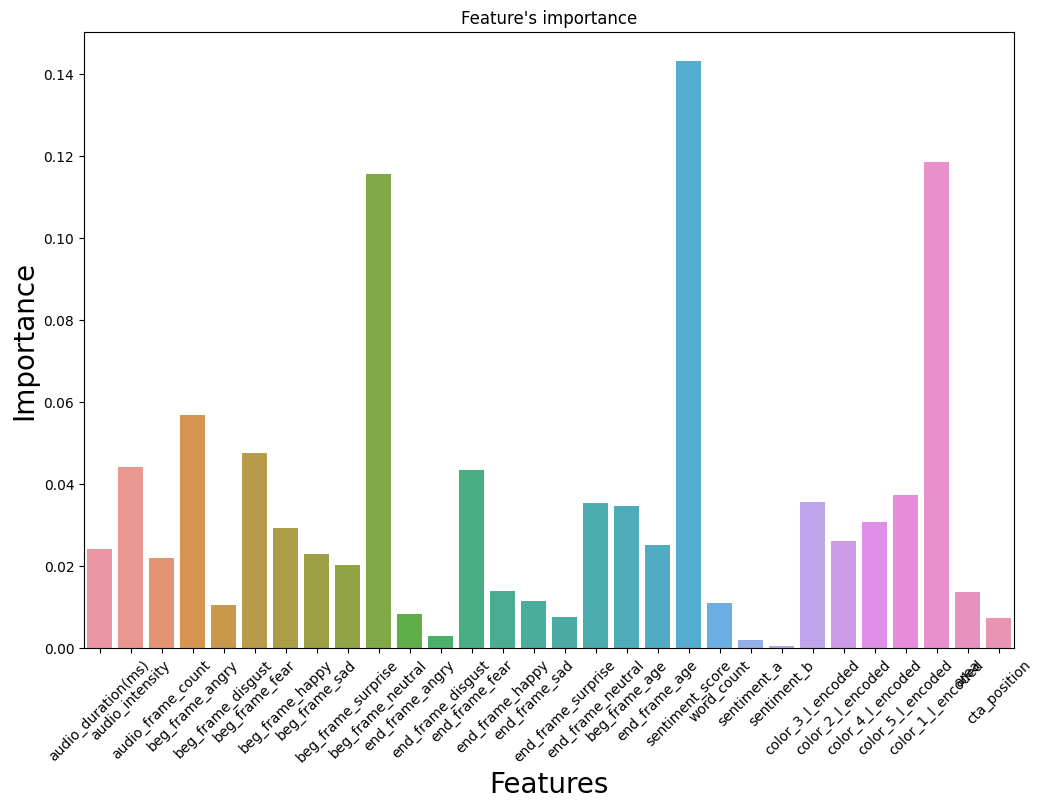

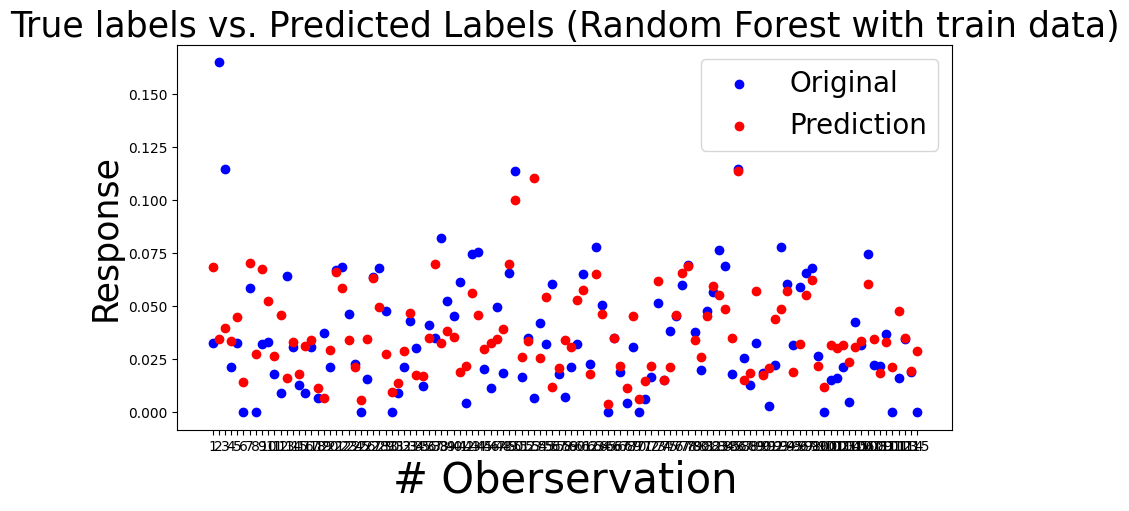

plotted prediction vs true labels
{'RMSE Score': 0.02, 'R2_Squared': 0.28, 'MAE Score': 0.02}
{'Accuracy': 23.66}
{'audio_duration(ms)': 0.02399477563894038, 'audio_intensity': 0.04404635450918024, 'audio_frame_count': 0.02193557494230165, 'beg_frame_angry': 0.056842568149600176, 'beg_frame_disgust': 0.01031436981618615, 'beg_frame_fear': 0.047585226857619324, 'beg_frame_happy': 0.029095842056189224, 'beg_frame_sad': 0.02279022474667701, 'beg_frame_surprise': 0.020116912254357147, 'beg_frame_neutral': 0.11573076642957676, 'end_frame_angry': 0.00825900917513867, 'end_frame_disgust': 0.002765998721905097, 'end_frame_fear': 0.04337042022767764, 'end_frame_happy': 0.013884233477552788, 'end_frame_sad': 0.011456766119573586, 'end_frame_surprise': 0.007385104921070309, 'end_frame_neutral': 0.03536711953044127, 'beg_frame_age': 0.034569469916818085, 'end_frame_age': 0.02516724741114093, 'sentiment_score': 0.14323155750536987, 'word_count': 0.01080738939613452, 'sentiment_a': 0.001819278289576

{'RMSE Score': 0.02, 'R2_Squared': 0.28, 'MAE Score': 0.02}

In [159]:
run_train_pipeline(model, X, y, 
    experiment_name='Random Forest with train data',
    run_name='RandomForestRegressor(max_depth=64, random_state=0)')